In [1]:
import io
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import xgboost as xgb
from xgboost import XGBRegressor,XGBModel

In [2]:
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split,cross_val_predict,cross_val_score
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report,average_precision_score,r2_score,recall_score,f1_score,roc_auc_score,roc_curve,mean_absolute_error

In [3]:
from google.colab import files
uploaded=files.upload()

Saving train_Df64byy.csv to train_Df64byy (1).csv
Saving test_YCcRUnU.csv to test_YCcRUnU (1).csv


In [4]:
test=pd.read_csv("test_YCcRUnU.csv")
train=pd.read_csv("train_Df64byy.csv")

In [5]:
train.head(5)

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response
0,1,C3,3213,Rented,Individual,36,36,No,X1,14+,3.0,22,11628.0,0
1,2,C5,1117,Owned,Joint,75,22,No,X2,NaN,NaN,22,30510.0,0
2,3,C5,3732,Owned,Individual,32,32,No,NaN,1.0,1.0,19,7450.0,1
3,4,C24,4378,Owned,Joint,52,48,No,X1,14+,3.0,19,17780.0,0
4,5,C8,2190,Rented,Individual,44,44,No,X2,3.0,1.0,16,10404.0,0


In [6]:
test.head(5)

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium
0,50883,C1,156,Owned,Individual,30,30,No,NaN,6.0,3.0,5,11934.0
1,50884,C4,7,Owned,Joint,69,68,Yes,X1,3.0,3.0,18,32204.8
2,50885,C1,564,Rented,Individual,28,28,No,X3,2.0,4.0,17,9240.0
3,50886,C3,1177,Rented,Individual,23,23,No,X3,3.0,3.0,18,9086.0
4,50887,C1,951,Owned,Individual,75,75,No,X3,NaN,NaN,5,22534.0


In [7]:
train.columns,test.columns

(Index(['ID', 'City_Code', 'Region_Code', 'Accomodation_Type',
        'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
        'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
        'Reco_Policy_Cat', 'Reco_Policy_Premium', 'Response'],
       dtype='object'),
 Index(['ID', 'City_Code', 'Region_Code', 'Accomodation_Type',
        'Reco_Insurance_Type', 'Upper_Age', 'Lower_Age', 'Is_Spouse',
        'Health Indicator', 'Holding_Policy_Duration', 'Holding_Policy_Type',
        'Reco_Policy_Cat', 'Reco_Policy_Premium'],
       dtype='object'))

In [8]:
train.shape,test.shape

((50882, 14), (21805, 13))

In [9]:
train.dtypes

ID                           int64
City_Code                   object
Region_Code                  int64
Accomodation_Type           object
Reco_Insurance_Type         object
Upper_Age                    int64
Lower_Age                    int64
Is_Spouse                   object
Health Indicator            object
Holding_Policy_Duration     object
Holding_Policy_Type        float64
Reco_Policy_Cat              int64
Reco_Policy_Premium        float64
Response                     int64
dtype: object

Handling Missing Value

In [10]:
numerical_ver=[]
categorical_ver=[]
for col in train.columns:
  if train[col].dtypes=='O':
    categorical_ver.append(col)
  else:
    numerical_ver.append(col)

In [11]:
train.isnull().sum()/len(train.isnull())*100

ID                          0.000000
City_Code                   0.000000
Region_Code                 0.000000
Accomodation_Type           0.000000
Reco_Insurance_Type         0.000000
Upper_Age                   0.000000
Lower_Age                   0.000000
Is_Spouse                   0.000000
Health Indicator           22.976691
Holding_Policy_Duration    39.799929
Holding_Policy_Type        39.799929
Reco_Policy_Cat             0.000000
Reco_Policy_Premium         0.000000
Response                    0.000000
dtype: float64

Now, we see that Health Indicater, Holding_Policy_Duration and Holding_Policy_Type has a 22%, 39% and 39% respectively null values.
 

In [12]:
test.isna().sum()/len(train.isna())*100

ID                          0.000000
City_Code                   0.000000
Region_Code                 0.000000
Accomodation_Type           0.000000
Reco_Insurance_Type         0.000000
Upper_Age                   0.000000
Lower_Age                   0.000000
Is_Spouse                   0.000000
Health Indicator            9.879722
Holding_Policy_Duration    16.907747
Holding_Policy_Type        16.907747
Reco_Policy_Cat             0.000000
Reco_Policy_Premium         0.000000
dtype: float64

In [13]:
def Null_values(df):
  t_na=df.isna()
  null_v=[]
  col=df.columns
  for i in np.arange(df.shape[1]):
    c=col[i]
    s1=0
    for j in np.arange(len(t_na[c])):
      s2=int(t_na[c][j])
      s1=s1+s2
    null_v=np.append(null_v,s1)
  n1=pd.DataFrame([col,null_v]).T
  return n1



In [14]:
Null_values(train)

,0,1
0,ID,0
1,City_Code,0
2,Region_Code,0
3,Accomodation_Type,0
4,Reco_Insurance_Type,0
5,Upper_Age,0
6,Lower_Age,0
7,Is_Spouse,0
8,Health Indicator,11691
9,Holding_Policy_Duration,20251


In [15]:
Null_values(test)

,0,1
0,ID,0
1,City_Code,0
2,Region_Code,0
3,Accomodation_Type,0
4,Reco_Insurance_Type,0
5,Upper_Age,0
6,Lower_Age,0
7,Is_Spouse,0
8,Health Indicator,5027
9,Holding_Policy_Duration,8603


In [16]:
var=['Health Indicator','Holding_Policy_Duration','Holding_Policy_Type']
for i in var:
  print(train[i].unique())
  print(train[i].value_counts())

['X1' 'X2' nan 'X4' 'X3' 'X6' 'X5' 'X8' 'X7' 'X9']
X1    13010
X2    10332
X3     6762
X4     5743
X5     1727
X6     1280
X7      196
X8       78
X9       63
Name: Health Indicator, dtype: int64
['14+' nan '1.0' '3.0' '5.0' '9.0' '14.0' '7.0' '2.0' '11.0' '10.0' '8.0'
 '6.0' '4.0' '13.0' '12.0']
1.0     4499
14+     4335
2.0     4260
3.0     3586
4.0     2771
5.0     2362
6.0     1894
7.0     1645
8.0     1316
9.0     1114
10.0     813
11.0     546
12.0     513
13.0     511
14.0     466
Name: Holding_Policy_Duration, dtype: int64
[ 3. nan  1.  4.  2.]
3.0    13279
1.0     8173
2.0     5005
4.0     4174
Name: Holding_Policy_Type, dtype: int64


In [17]:
"In train data set Health_Indicator, Holding_Policy_Duration and Holding_Policy_Type are lots of missing values. We see two of categorical data and one of numerical data then we use mode for categorical data and mean for numerical data."

'In train data set Health_Indicator, Holding_Policy_Duration and Holding_Policy_Type are lots of missing values. We see two of categorical data and one of numerical data then we use mode for categorical data and mean for numerical data.'

In [18]:
imputer=SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit(train.iloc[:,8:11])
train.iloc[:,8:11]=imputer.transform(train.iloc[:,8:11])

In [19]:
imputer=SimpleImputer(missing_values=np.nan, strategy='most_frequent')
imputer.fit(test.iloc[:,8:11])
test.iloc[:,8:11]=imputer.transform(test.iloc[:,8:11])

Exploretery Data Analysis

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Number of Client')

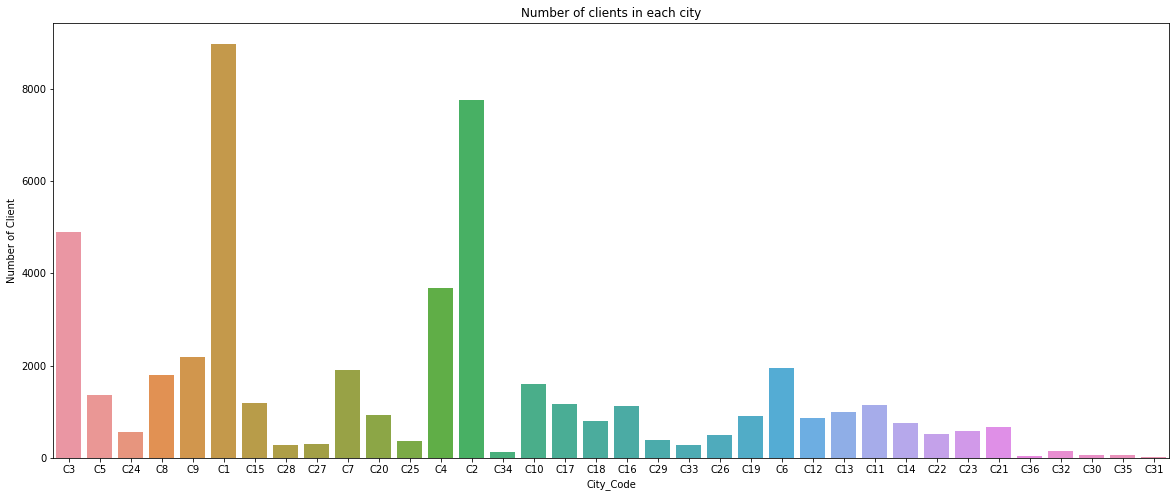

In [20]:
plt.figure(figsize=(20,8))
sns.countplot(train['City_Code'])
plt.title("Number of clients in each city")
plt.xlabel("City_Code")
plt.ylabel("Number of Client")

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'Number of Client')

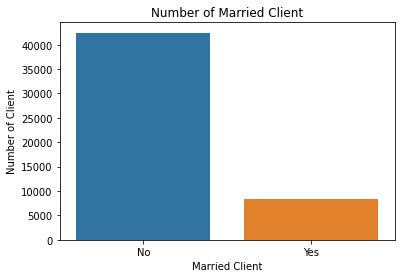

In [21]:
sns.countplot(train['Is_Spouse'])
plt.title("Number of Married Client")
plt.xlabel("Married Client")
plt.ylabel("Number of Client")

Text(0, 0.5, 'Number of Client')

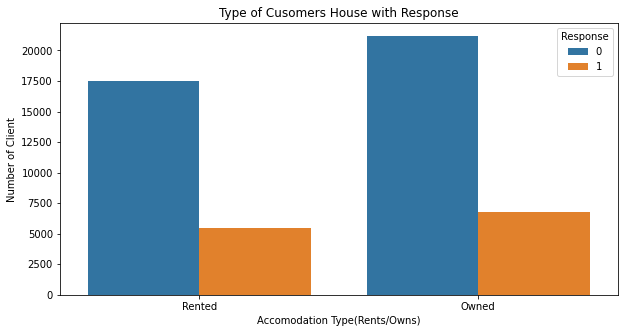

In [22]:
plt.figure(figsize=(10,5))
sns.countplot(data=train,x='Accomodation_Type',hue='Response',)
plt.title("Type of Cusomers House with Response")
plt.xlabel("Accomodation Type(Rents/Owns)")
plt.ylabel("Number of Client")

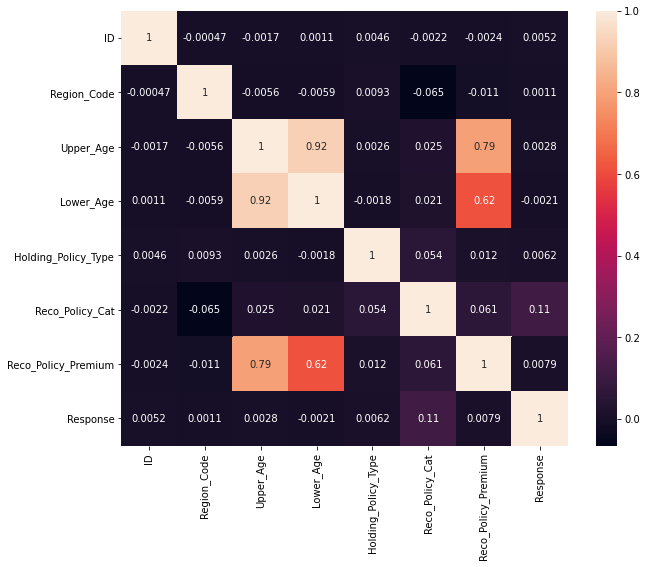

In [23]:
df_corr=train.corr()
f=plt.subplots(figsize=(10,8))
sns.heatmap(df_corr,annot=True)

Text(0.5, 1.0, 'Lower_Age')

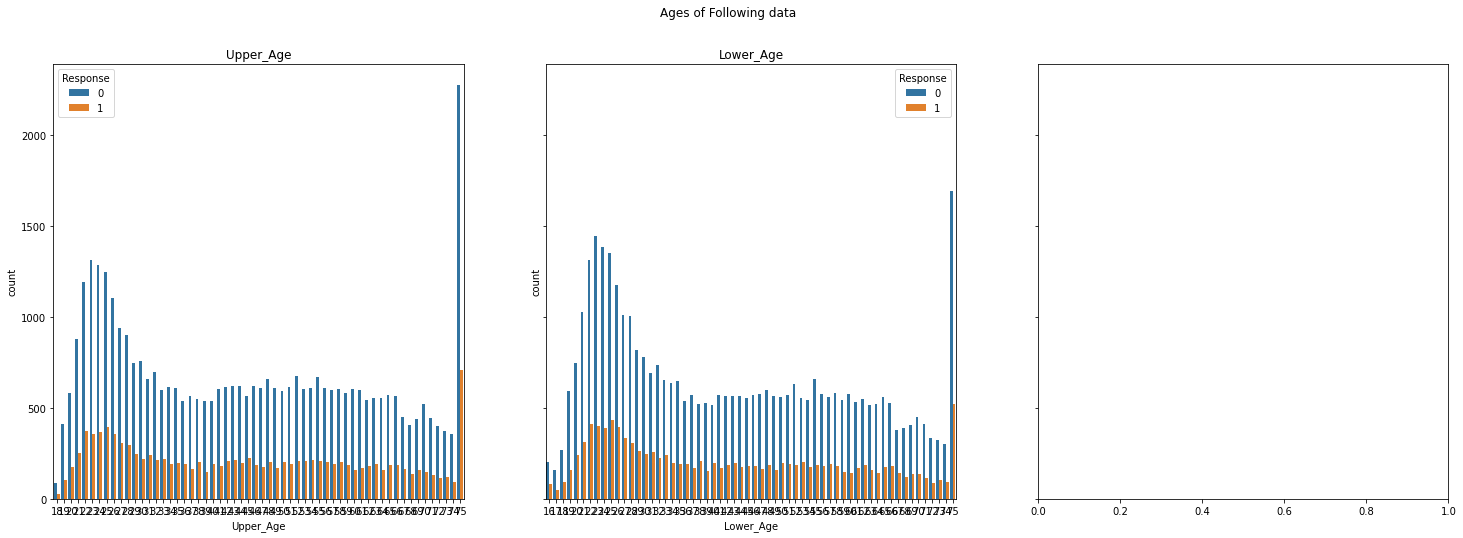

In [24]:
fig, axes = plt.subplots(1, 3, figsize=(25, 8), sharey=True)
fig.suptitle('Ages of Following data')
sns.countplot(ax=axes[0],data=train,x='Upper_Age',hue='Response')
axes[0].set_title('Upper_Age')
sns.countplot(ax=axes[1],data=train,x='Lower_Age',hue='Response')
axes[1].set_title('Lower_Age')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


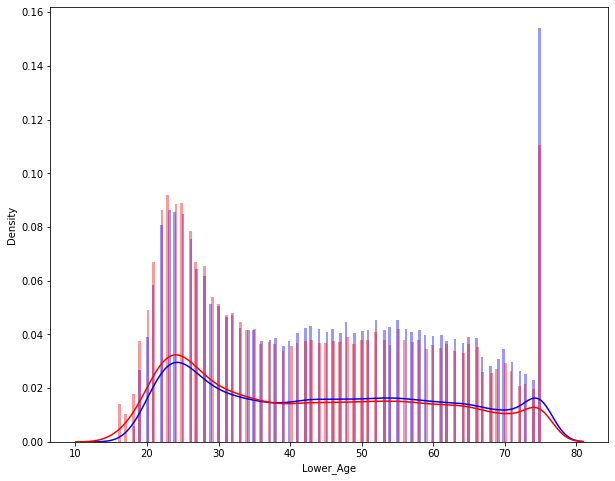

In [25]:
f=plt.subplots(figsize=(10,8))
sns.distplot(train['Upper_Age'],kde=True,color="b",bins=150,)
sns.distplot(train['Lower_Age'],kde=True,color="r",bins=150)

Text(0.5, 1.0, 'Percentage of Married persons')

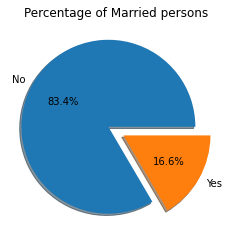

In [26]:
r=pd.get_dummies(train['Is_Spouse'])
r1=(sum(r["No"]),sum(r["Yes"]))
plt.pie(r1,labels=["No","Yes"],shadow=True,explode=(.1,.1),autopct='%1.1f%%')
plt.title("Percentage of Married persons")

Text(0.5, 1.0, 'Percentage of Response')

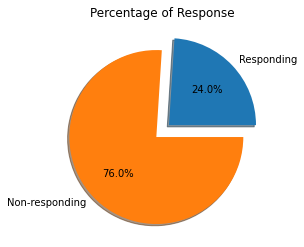

In [27]:
r=pd.get_dummies(train['Response'])
r1=(sum(r[1]),sum(r[0]))
plt.pie(r1,labels=["Responding","Non-responding"],shadow=True,explode=(.1,.1),autopct='%1.1f%%')
plt.title("Percentage of Response")

Text(0.5, 1.0, 'Percentage of Accomodation_Type')

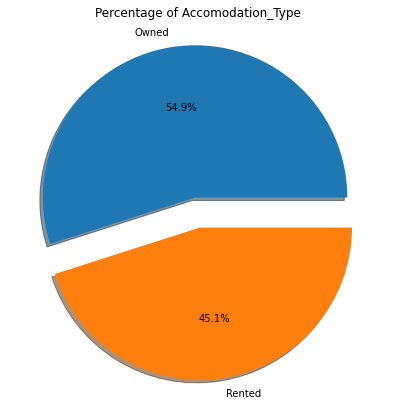

In [28]:
r=pd.get_dummies(train['Accomodation_Type'])
r1=(sum(r["Owned"]),sum(r["Rented"]))
plt.figure(figsize=(7,7))
plt.pie(r1,labels=["Owned","Rented"],shadow=True,explode=(.1,.1),autopct='%1.1f%%')
plt.title("Percentage of Accomodation_Type")

Text(0.5, 1.0, 'Percentage of Health_Indicator')

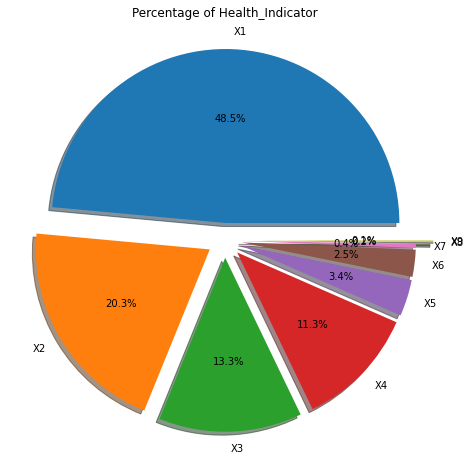

In [29]:
r=pd.get_dummies(train['Health Indicator'])
plt.figure(figsize=(8,8))
r1=(sum(r["X1"]),sum(r["X2"]),sum(r["X3"]),sum(r["X4"]),sum(r["X5"]),sum(r["X6"]),sum(r["X7"]),sum(r["X8"]),sum(r["X9"]))
plt.pie(r1,labels=["X1","X2","X3","X4","X5","X6","X7","X8","X9"],shadow=True,explode=(.1,.1,.1,.1,.1,.1,.1,.2,.2),autopct='%1.1f%%')
plt.title("Percentage of Health_Indicator")

([<matplotlib.patches.Wedge at 0x7f55f7e0ef10>,
 [Text(-0.9633812721178808, 0.7154694434652915, 'Indiviudal'),
  Text(0.9633812721178804, -0.715469443465292, 'Joint')],
 [Text(-0.5619724087354304, 0.4173571753547533, '79.7%'),
  Text(0.5619724087354302, -0.41735717535475364, '20.3%')])

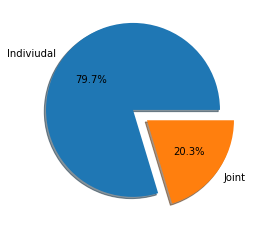

In [30]:
r=pd.get_dummies(train['Reco_Insurance_Type'])
r1=(sum(r["Individual"]),sum(r["Joint"]))
plt.pie(r1,labels=["Indiviudal","Joint"],shadow=True,explode=(.1,.1),autopct='%1.1f%%')

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


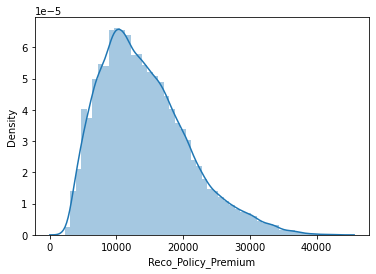

In [31]:
sns.distplot(train['Reco_Policy_Premium'])

<Figure size 720x360 with 0 Axes>

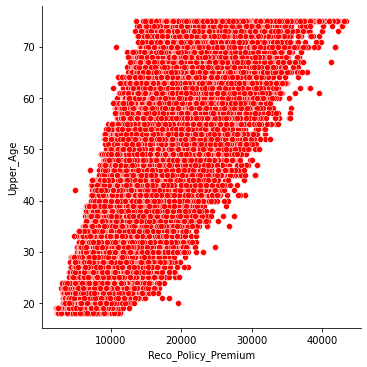

In [32]:
plt.figure(figsize=(10,5))
sns.relplot(data=train,x='Reco_Policy_Premium',y='Upper_Age',color='red')

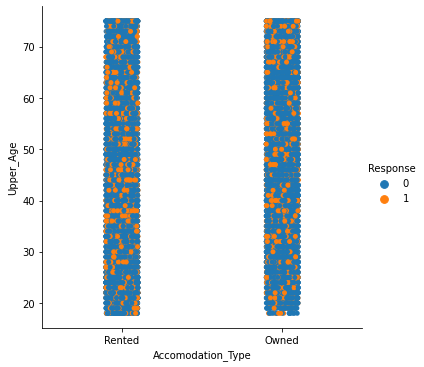

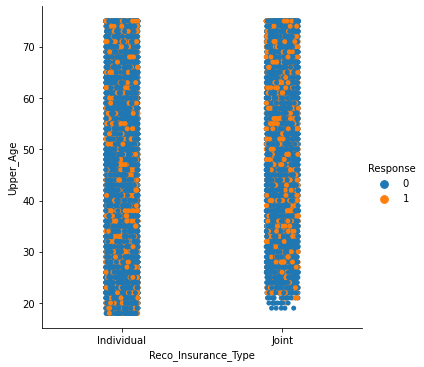

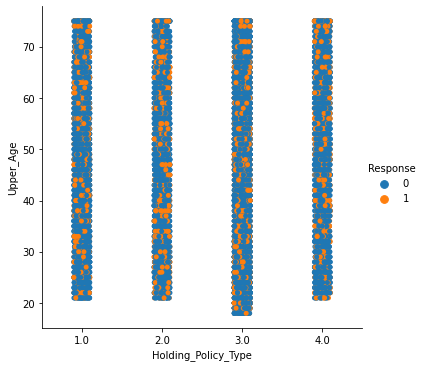

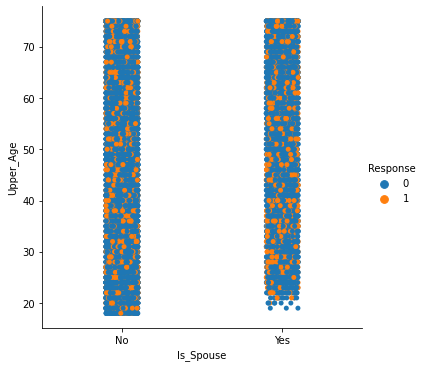

In [33]:
C=['Accomodation_Type','Reco_Insurance_Type','Holding_Policy_Type','Is_Spouse']
for i in C:
    sns.catplot(data=train,x=i,y='Upper_Age',hue='Response',kind="strip")

Feature Engineering

In [34]:
#Removing C in City_Code
train['City_Code']=train['City_Code'].str[1:]
train['City_Code']=train['City_Code'].astype(int)
test['City_Code']=test['City_Code'].str[1:]
test['City_Code']=test['City_Code'].astype(int)

In [35]:
train['Holding_Policy_Duration']=train['Holding_Policy_Duration'].replace(to_replace='14+',value=15).astype(float)
test['Holding_Policy_Duration']=test['Holding_Policy_Duration'].replace(to_replace='14+',value=15).astype(float)

In [36]:
train['New_Cus']=np.where(np.logical_and((train['Holding_Policy_Duration']==0),(train['Holding_Policy_Type']==0)),1,0)
test['New_Cus']=np.where(np.logical_and((test['Holding_Policy_Duration']==0),(test['Holding_Policy_Type']==0)),1,0)

In [37]:
train['Accom_Is_Spouse']=train['Accomodation_Type']+"_"+train['Is_Spouse']
test['Accom_Is_Spouse']=test['Accomodation_Type']+"_"+test['Is_Spouse']

In [38]:
train['Accom_are_Reco']=train['Accomodation_Type']+"_"+train['Reco_Insurance_Type']
test['Accom_are_Reco']=test['Accomodation_Type']+"_"+test['Reco_Insurance_Type']

In [39]:
train['Reco_Spou']=train['Is_Spouse']+"_"+train['Reco_Insurance_Type']
test['Reco_Spou']=test['Is_Spouse']+"_"+test['Reco_Insurance_Type']

In [40]:
train['Age_diff']=train['Upper_Age']-train['Lower_Age']
train['Age_diff']=train['Age_diff'].astype(int)
test['Age_diff']=test['Upper_Age']-test['Lower_Age']
test['Age_diff']=test['Age_diff'].astype(int)

In [41]:
train['Family']=np.where(train['Age_diff']>0,1,0)
test['Family']=np.where(test['Age_diff']>0,1,0)

In [42]:
# Now we change categorical to numerical by using One_Hot_Encoding
train['Reco_Insurance_Type']=np.where(train['Reco_Insurance_Type']=="Joint",1,0)
test['Reco_Insurance_Type']=np.where(test['Reco_Insurance_Type']=="Joint",1,0)
train['Is_Spouse']=np.where(train['Is_Spouse']=="Yes",1,0)
test['Is_Spouse']=np.where(test['Is_Spouse']=="Yes",1,0)
train['Accomodation_Type']=np.where(train['Accomodation_Type']=="Owened",1,0)
test['Accomodation_Type']=np.where(test['Accomodation_Type']=="Owened",1,0)
train['Holding_Policy_Type']=train['Holding_Policy_Type'].astype(str)
test['Holding_Policy_Type']=test['Holding_Policy_Type'].astype(str)

In [43]:
dummies_HPT = pd.get_dummies(train["Holding_Policy_Type"], prefix = 'HPT',drop_first=True)
train= pd.concat([train, dummies_HPT], axis = 1)
dummies_HPT = pd.get_dummies(test["Holding_Policy_Type"], prefix = 'HPT',drop_first=True)
test = pd.concat([test, dummies_HPT], axis = 1)

In [44]:
train["log_Premium"]=np.log(train["Reco_Policy_Premium"])
test["log_Premium"]=np.log(test["Reco_Policy_Premium"])

In [45]:
topcity_10=train.City_Code.value_counts().sort_values(ascending=False).head(10).index
lst_10=list(topcity_10)
for categories in lst_10:
    train["City_code:"+str(categories)]=np.where(train['City_Code']==categories,1,0)
    test["City_code:"+str(categories)]=np.where(test['City_Code']==categories,1,0)

In [46]:
topregion_10=train.Region_Code.value_counts().sort_values(ascending=False).head(10).index
lst_10=list(topregion_10)
for categories in lst_10:
    train["Region_code:"+str(categories)]=np.where(train['Region_Code']==categories,1,0)
    test["Region_code:"+str(categories)]=np.where(test['Region_Code']==categories,1,0)

In [47]:
bins = [15,21,30,40,55,75]
labels = ['young','adult','middle-aged','old','very_old']
train['Upper_age_group'] = pd.cut(train['Upper_Age'],bins = bins, labels = labels)
test['Upper_age_group'] = pd.cut(test['Upper_Age'],bins = bins, labels = labels)
train['Lower_age_group'] = pd.cut(train['Lower_Age'],bins = bins, labels = labels)
test['Lower_age_group'] = pd.cut(test['Lower_Age'],bins = bins, labels = labels)

In [48]:
train['Insurance_Age']=np.where((train['New_Cus']==1),0,train['Upper_Age']-train['Holding_Policy_Duration'])
test['Insurance_Age']=np.where((test['New_Cus']==1),0,test['Upper_Age']-test['Holding_Policy_Duration'])

In [49]:
labels= ["not_customer","new_customer","old_customer","valued_customer","Very_valued_customer"]
bins=[-1.0,0.0,5.0,10.0,14.0,15.0]
train["Cust_Acq"] = pd.cut(train["Holding_Policy_Duration"] , labels= labels, bins=bins)
test["Cust_Acq"] = pd.cut(test["Holding_Policy_Duration"] , labels= labels, bins=bins)

In [50]:
labels= ["below-10k","10k-30k","above-30k"]
bins=[2000,10000,30000,50000]
train["Premium_category"] = pd.cut(train["Reco_Policy_Premium"] , labels= labels, bins=bins)
test["Premium_category"] = pd.cut(test["Reco_Policy_Premium"] , labels= labels, bins=bins)

In [51]:
dummies_HPT = pd.get_dummies(train["Premium_category"], prefix = 'PRE_CAT',drop_first=True)
train= pd.concat([train, dummies_HPT], axis = 1)
dummies_HPT = pd.get_dummies(test["Premium_category"], prefix = 'PRE_CAT',drop_first=True)
test= pd.concat([test, dummies_HPT], axis = 1)
train.drop("Premium_category",axis=1,inplace=True)
test.drop("Premium_category",axis=1,inplace=True)

In [52]:
train['Upper_age_group']=train['Upper_age_group'].astype(str)
test['Upper_age_group']=test['Upper_age_group'].astype(str)
train['Lower_age_group']=train['Lower_age_group'].astype(str)
test['Lower_age_group']=test['Lower_age_group'].astype(str)
train["Cust_Acq"]=train["Cust_Acq"].astype(str)
test["Cust_Acq"]=test["Cust_Acq"].astype(str)

In [53]:
train.head(10)

,ID,City_Code,Region_Code,Accomodation_Type,Reco_Insurance_Type,Upper_Age,Lower_Age,Is_Spouse,Health Indicator,Holding_Policy_Duration,Holding_Policy_Type,Reco_Policy_Cat,Reco_Policy_Premium,Response,New_Cus,Accom_Is_Spouse,Accom_are_Reco,Reco_Spou,Age_diff,Family,HPT_2.0,HPT_3.0,HPT_4.0,log_Premium,City_code:1,City_code:2,City_code:3,City_code:4,City_code:9,City_code:6,City_code:7,City_code:8,City_code:10,City_code:5,Region_code:1,Region_code:5,Region_code:2,Region_code:6,Region_code:4,Region_code:10,Region_code:7,Region_code:8,Region_code:16,Region_code:20,Upper_age_group,Lower_age_group,Insurance_Age,Cust_Acq,PRE_CAT_10k-30k,PRE_CAT_above-30k
0,1,3,3213,0,0,36,36,0,X1,15.0,3.0,22,11628.0,0,0,Rented_No,Rented_Individual,No_Individual,0,0,0,1,0,9.361171,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,middle-aged,middle-aged,21.0,Very_valued_customer,1,0
1,2,5,1117,0,1,75,22,0,X2,1.0,3.0,22,30510.0,0,0,Owned_No,Owned_Joint,No_Joint,53,1,0,1,0,10.325810,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,very_old,adult,74.0,new_customer,0,1
2,3,5,3732,0,0,32,32,0,X1,1.0,1.0,19,7450.0,1,0,Owned_No,Owned_Individual,No_Individual,0,0,0,0,0,8.915969,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,middle-aged,middle-aged,31.0,new_customer,0,0
3,4,24,4378,0,1,52,48,0,X1,15.0,3.0,19,17780.0,0,0,Owned_No,Owned_Joint,No_Joint,4,1,0,1,0,9.785830,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,old,old,37.0,Very_valued_customer,1,0
4,5,8,2190,0,0,44,44,0,X2,3.0,1.0,16,10404.0,0,0,Rented_No,Rented_Individual,No_Individual,0,0,0,0,0,9.249946,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,old,old,41.0,new_customer,1,0
5,6,9,1785,0,0,52,52,0,X2,5.0,1.0,22,15264.0,1,0,Rented_No,Rented_Individual,No_Individual,0,0,0,0,0,9.633252,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,old,old,47.0,new_customer,1,0
6,7,3,679,0,0,28,28,0,X1,1.0,3.0,17,10640.0,0,0,Owned_No,Owned_Individual,No_Individual,0,0,0,1,0,9.272376,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,adult,adult,27.0,new_customer,1,0
7,8,1,3175,0,1,75,73,1,X4,9.0,4.0,17,29344.0,1,0,Owned_Yes,Owned_Joint,Yes_Joint,2,1,0,0,1,10.286843,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,very_old,very_old,66.0,old_customer,1,0
8,9,15,3497,0,1,52,43,0,X1,14.0,3.0,1,27283.2,0,0,Owned_No,Owned_Joint,No_Joint,9,1,0,1,0,10.214026,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,old,old,38.0,valued_customer,1,0
9,10,1,530,0,1,59,26,1,X1,7.0,4.0,18,21100.8,1,0,Owned_Yes,Owned_Joint,Yes_Joint,33,1,0,0,1,9.957066,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,very_old,adult,52.0,old_customer,1,0


In [54]:
round((train['Accom_are_Reco'].value_counts()/len(train['Accom_are_Reco']))*100,2)

Rented_Individual    39.85
Owned_Individual     39.82
Owned_Joint          15.11
Rented_Joint          5.22
Name: Accom_are_Reco, dtype: float64

Text(0.5, 1.0, 'Percentage of customers who Rents/Owns a house while taking Individual/Joint Insurance')

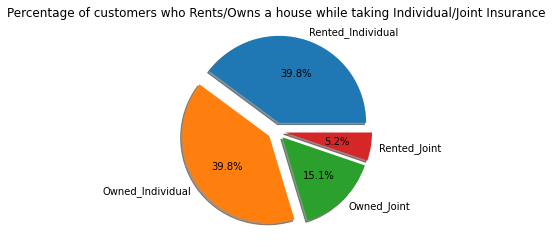

In [55]:
r=pd.get_dummies(train['Accom_are_Reco'])
r1=(sum(r["Rented_Individual"]),sum(r["Owned_Individual"]),sum(r["Owned_Joint"]),sum(r["Rented_Joint"]))
plt.pie(r1,labels=["Rented_Individual","Owned_Individual","Owned_Joint","Rented_Joint"],shadow=True,explode=(.1,.1,.1,.1),autopct='%1.1f%%')
plt.title("Percentage of customers who Rents/Owns a house while taking Individual/Joint Insurance")

In [56]:
round((train['Accom_Is_Spouse'].value_counts()/len(train['Accom_Is_Spouse']))*100,2)

Owned_No      42.31
Rented_No     41.14
Owned_Yes     12.63
Rented_Yes     3.93
Name: Accom_Is_Spouse, dtype: float64

Text(0.5, 1.0, 'Percentage of customers who Rents/Owns a house while gating Married')

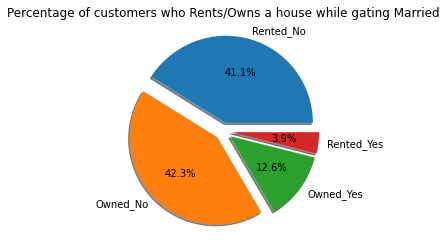

In [57]:
r=pd.get_dummies(train['Accom_Is_Spouse'])
r1=(sum(r["Rented_No"]),sum(r["Owned_No"]),sum(r["Owned_Yes"]),sum(r["Rented_Yes"]))
plt.pie(r1,labels=["Rented_No","Owned_No","Owned_Yes","Rented_Yes"],shadow=True,explode=(.1,.1,.1,.1),autopct='%1.1f%%')
plt.title("Percentage of customers who Rents/Owns a house while gating Married")

In [58]:
round((train['Lower_age_group'].value_counts()/len(train['Lower_age_group']))*100,2)

very_old       27.58
adult          26.45
old            22.38
middle-aged    15.87
young           7.72
Name: Lower_age_group, dtype: float64

Text(0.5, 1.0, 'Percentage of customers who belong Lower age group')

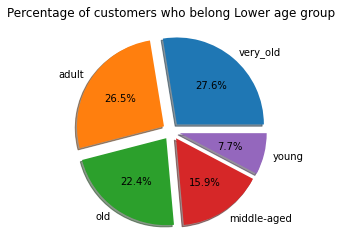

In [59]:
r=pd.get_dummies(train['Lower_age_group'])
r1=(sum(r["very_old"]),sum(r["adult"]),sum(r["old"]),sum(r["middle-aged"]),sum(r["young"]))
plt.pie(r1,labels=["very_old","adult","old","middle-aged","young"],shadow=True,explode=(.1,.1,.1,.1,.1),autopct='%1.1f%%')
plt.title("Percentage of customers who belong Lower age group")

In [60]:
round((train['Upper_age_group'].value_counts()/len(train['Upper_age_group']))*100,2)

very_old       31.10
adult          24.38
old            24.12
middle-aged    15.45
young           4.95
Name: Upper_age_group, dtype: float64

Text(0.5, 1.0, 'Percentage of customers who belong upper age group')

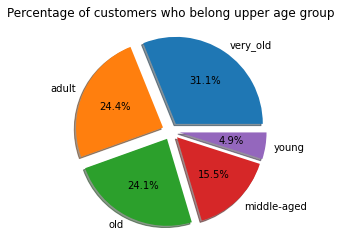

In [61]:
r=pd.get_dummies(train['Upper_age_group'])
r1=(sum(r["very_old"]),sum(r["adult"]),sum(r["old"]),sum(r["middle-aged"]),sum(r["young"]))
plt.pie(r1,labels=["very_old","adult","old","middle-aged","young"],shadow=True,explode=(.1,.1,.1,.1,.1),autopct='%1.1f%%')
plt.title("Percentage of customers who belong upper age group")

In [62]:
round((train['Reco_Spou'].value_counts()/len(train['Reco_Spou']))*100,2)

No_Individual    79.67
Yes_Joint        16.55
No_Joint          3.78
Name: Reco_Spou, dtype: float64

In [63]:
round((train['Cust_Acq'].value_counts()/len(train['Cust_Acq']))*100,2)

new_customer            74.15
old_customer            13.33
Very_valued_customer     8.52
valued_customer          4.00
Name: Cust_Acq, dtype: float64

Text(0.5, 1.0, 'Percentage of customers who very valuable for company ')

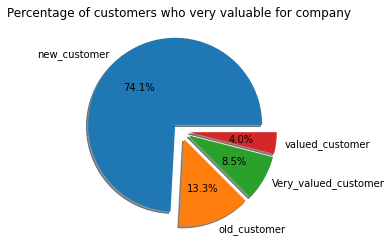

In [64]:
r=pd.get_dummies(train['Cust_Acq'])
r1=(sum(r["new_customer"]),sum(r["old_customer"]),sum(r["Very_valued_customer"]),sum(r["valued_customer"]))
plt.pie(r1,labels=["new_customer","old_customer","Very_valued_customer","valued_customer"],shadow=True,explode=(.1,.1,.1,.1),autopct='%1.1f%%')
plt.title("Percentage of customers who very valuable for company ")

In [65]:
train.groupby(['Cust_Acq','Upper_age_group'])['Insurance_Age'].mean()

Cust_Acq              Upper_age_group
Very_valued_customer  middle-aged        22.631387
                      old                33.656429
                      very_old           51.985720
new_customer          adult              23.817032
                      middle-aged        33.184054
                      old                46.017518
                      very_old           63.982938
                      young              19.151371
old_customer          adult              21.547923
                      middle-aged        27.541912
                      old                40.295775
                      very_old           58.398860
valued_customer       middle-aged        23.907186
                      old                35.972892
                      very_old           54.058767
Name: Insurance_Age, dtype: float64

In [66]:
train.groupby(['Cust_Acq','Lower_age_group'])['Insurance_Age'].mean()

Cust_Acq              Lower_age_group
Very_valued_customer  adult              43.405941
                      middle-aged        26.871720
                      old                35.322932
                      very_old           52.398723
                      young              38.288344
new_customer          adult              25.156963
                      middle-aged        34.613104
                      old                47.265035
                      very_old           64.403786
                      young              25.699571
old_customer          adult              25.674787
                      middle-aged        29.295695
                      old                41.860603
                      very_old           58.919082
                      young              41.163366
valued_customer       adult              39.431373
                      middle-aged        26.268617
                      old                37.946625
                      very_old           54.

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


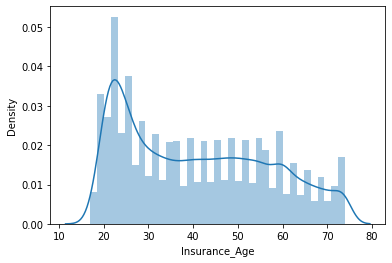

In [67]:
sns.distplot(train['Insurance_Age'])

In [68]:
pip install category_encoders

In [69]:
from category_encoders import TargetEncoder
te = TargetEncoder()
train['Region_Code_encoding'] = te.fit_transform(train['Region_Code'].astype(str), train['Response'])
test['Region_Code_encoding'] = te.transform(test['Region_Code'].astype(str))
te=TargetEncoder()
train['City_Code_encoding'] = te.fit_transform(train['City_Code'].astype(str), train['Response'])
test['City_Code_encoding'] = te.transform(test['City_Code'].astype(str))

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.7/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [70]:
train.drop(["ID","Holding_Policy_Type","Region_Code","City_Code"],axis=1,inplace=True)
test.drop(["ID","Holding_Policy_Type","Region_Code","City_Code"],axis=1,inplace=True)

In [71]:
numerical_ver=[]
categorical_ver=[]
for col in train.columns:
  if train[col].dtypes=='O':
    categorical_ver.append(col)
  else:
    numerical_ver.append(col)

In [72]:
numerical_ver=[]
categorical_ver=[]
for col in test.columns:
  if test[col].dtypes=='O':
    categorical_ver.append(col)
  else:
    numerical_ver.append(col)

In [73]:
for var in categorical_ver:
    le=preprocessing.LabelEncoder()
    train[var]=le.fit_transform(train[var].astype('str'))
train.dtypes

Accomodation_Type            int64
Reco_Insurance_Type          int64
Upper_Age                    int64
Lower_Age                    int64
Is_Spouse                    int64
Health Indicator             int64
Holding_Policy_Duration    float64
Reco_Policy_Cat              int64
Reco_Policy_Premium        float64
Response                     int64
New_Cus                      int64
Accom_Is_Spouse              int64
Accom_are_Reco               int64
Reco_Spou                    int64
Age_diff                     int64
Family                       int64
HPT_2.0                      uint8
HPT_3.0                      uint8
HPT_4.0                      uint8
log_Premium                float64
City_code:1                  int64
City_code:2                  int64
City_code:3                  int64
City_code:4                  int64
City_code:9                  int64
City_code:6                  int64
City_code:7                  int64
City_code:8                  int64
City_code:10        

In [74]:
for var in categorical_ver:
    le=preprocessing.LabelEncoder()
    test[var]=le.fit_transform(test[var].astype('str'))

In [75]:
X=train.drop(columns='Response',axis=0)
y=train['Response']

In [76]:
from imblearn.over_sampling import SMOTE 
sm = SMOTE(sampling_strategy = 1 ,k_neighbors = 5, random_state=1)   
X_smote, y = sm.fit_resample(X, y)

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [77]:
from sklearn.preprocessing import StandardScaler,Normalizer
from sklearn import metrics
from sklearn.metrics import mean_squared_error
stc=StandardScaler()
X_smote=stc.fit_transform(X_smote)
test=stc.transform(test)

In [78]:
X_smote = pd.DataFrame(X_smote,columns=X.columns)
test=pd.DataFrame(test,columns=X.columns)
X_smote.drop(["City_Code_encoding","Region_Code_encoding",],axis=1,inplace=True)
test.drop(["City_Code_encoding","Region_Code_encoding"],axis=1,inplace=True)

In [79]:
X_train,X_test,y_train,y_test=train_test_split(X_smote,y,test_size=0.4,random_state=22)

In [80]:
xgbc=xgb.XGBClassifier()
xgbc.fit(X_train,y_train)
xgbc_prediction = xgbc.predict(X_train)
xgbc_score= accuracy_score(y_train,xgbc_prediction)
print('accuracy Score on train using XGBClassifier:',xgbc_score)

accuracy Score on train using XGBClassifier: 0.8335380438295946


In [81]:
a1=mean_absolute_error(y_train,xgbc_prediction)
a1

0.16646195617040532

In [82]:
Con_matrix_tr=confusion_matrix(y_train,xgbc_prediction)
print('Confusin metrix:',Con_matrix_tr)

Confusin metrix: [[23148     0]
 [ 7725 15534]]


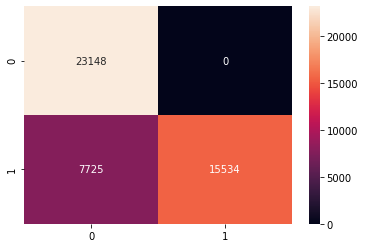

In [83]:
sns.heatmap(confusion_matrix(y_train,xgbc_prediction),annot=True,fmt="d")

In [95]:
print("Classification Report:")
print(classification_report(y_train,xgbc_prediction))

Classification Report:
              precision    recall  f1-score   support

           0       0.75      1.00      0.86     23148
           1       1.00      0.67      0.80     23259

    accuracy                           0.83     46407
   macro avg       0.87      0.83      0.83     46407
weighted avg       0.88      0.83      0.83     46407



In [85]:
average_precision_tr = average_precision_score(y_train,xgbc_prediction )
Re_score_tr=recall_score(y_train, xgbc_prediction)
F1_score_tr=f1_score(y_train, xgbc_prediction)

In [86]:
xgbc_predict=xgbc.predict(X_test)
accuracy_score_ts= accuracy_score(y_test,xgbc_predict)
Con_matrix_ts=confusion_matrix(y_test,xgbc_predict)
average_precision_ts = average_precision_score(y_test, xgbc_predict)
F1_score_ts=f1_score(y_test, xgbc_predict)
Re_score_ts=recall_score(y_test, xgbc_predict)

In [87]:
data=pd.DataFrame({'Accuracy_score':[xgbc_score,accuracy_score_ts],'Confusion_matrix':[Con_matrix_tr,Con_matrix_ts],
                  'Average_precision_score':[average_precision_tr,average_precision_ts],'recall_score':[Re_score_tr,Re_score_ts]
                  ,'f1_score':[F1_score_tr,F1_score_ts]},
                 index=['Train','Test'])

In [88]:
np.transpose(data)

,Train,Test
Accuracy_score,0.833538,0.839297
Confusion_matrix,"[[23148, 0], [7725, 15534]]","[[15525, 0], [4972, 10442]]"
Average_precision_score,0.834332,0.838139
recall_score,0.667871,0.677436
f1_score,0.800866,0.807704
